<a href="https://colab.research.google.com/github/mekaviraj/ml_assignment_1/blob/main/mL_assignment_1_192.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# import statemnts

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
import matplotlib.pyplot as plt

#1. Regression



For this exercise, you will experiment with regression, regularization, and cross-validation. Choose appropriate Dataset.

Dataset chosen: Boston Housing Dataset (HousingData.csv)

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston, Massachusetts. It consists of 506 instances and 14 attributes. The variables describe socioeconomic, geographical, and structural characteristics of houses, while the target variable "MEDV" represents the median value of owner-occupied homes in $1000s.


In [32]:
# 1(a)Load the data into memory. Make an appropriate X matrix and y vector.


pth = "/content/HousingData.csv"
df = pd.read_csv(pth)

cols = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df = df[cols].dropna()

# X matrix (features) and y vector (target)
X = df.drop('MEDV', axis=1).values
y = df['MEDV'].values

print("X.shape:", X.shape)
print("y.shape:", y.shape)


X.shape: (394, 13)
y.shape: (394,)


In [34]:
# 1(b) Split the data at random into one set (Xtrain, ytrain) containing 80% of the instances, which will
# be used for training + validation, and a testing set Xtest, ytest) (containing remaining instances).

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

print("trn:", Xtr.shape, ytr.shape)
print("tst:", Xte.shape, yte.shape)


trn: (315, 13) (315,)
tst: (79, 13) (79,)


1(c) Give the objective of logistic regression with L2 regularization.

Ridge regression, also known as L2 regularization, is a technique used in linear regression to prevent overfitting by adding a penalty term to the loss function. This penalty is proportional to the square of the magnitude of the coefficients (weights).

Ridge Regression is a version of linear regression that includes a penalty to prevent the model from overfitting, especially when there are many predictors or not enough data.

The standard loss function (mean squared error) is modified to include a regularization term:


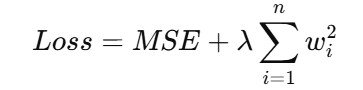

Here,
𝜆
λ is the regularization parameter that controls the strength of the penalty, and wi are the coefficients.

- Encouraging the model's coefficients to be small but not exactly zero.
- It helps to prevent any one feature from having an overly dominant   effect on the predictions.
- The larger the ' λ ' value, the stronger the regularization, and the smaller the coefficients will become

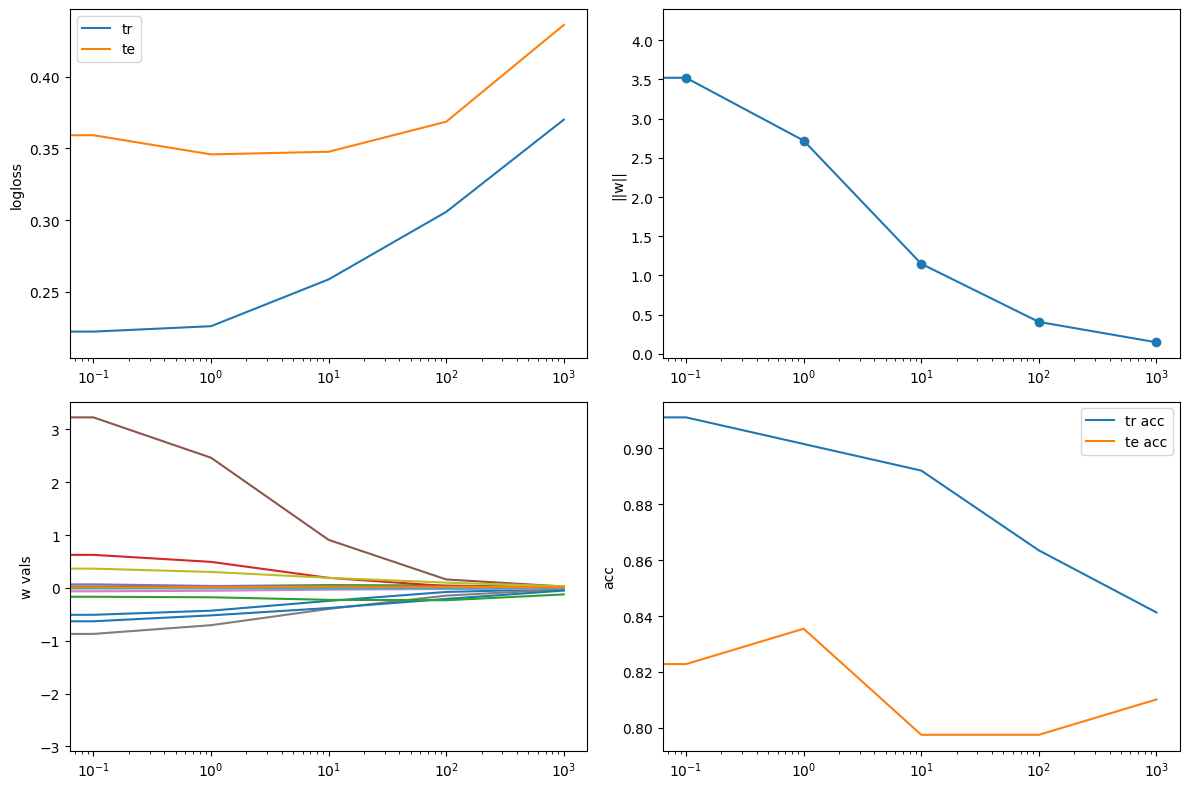

'When λ is very small (almost no regularization), the model fits strongly and weights become large, but test loss is not the best, showing some overfitting. As λ increases, the weight norm shrinks and training loss rises a bit, but test loss improves initially. At very high λ, the model becomes too constrained, accuracy drops, and it underfits. The plots clearly show the trade-off between weight size and generalization.'

In [36]:
# 1(d) Run logistic regression on the data using L2 regularization, varying the regularization parameter
# λ ∈ {0, 0.1, 1, 10, 100, 1000}. Plot on one graph the average cross-entropy for the training data
# and the testing data (averaged over all instances), as a function of λ (you should use a log scale
# for λ). Plot on another graph the L2 norm of the weight vector you obtain. Plot on the third
# graph the actual values of the weights obtained (one curve per weight). Finally, plot on a
# graph the accuracy on the training and test set. Explain briefly what you see.
lam = [0,0.1,1,10,100,1000]
tr_loss, te_loss, w_norm, acc_tr, acc_te, w_all = [],[],[],[],[],[]

# make y binary: >median = 1 else 0
ymed = np.median(ytr)
ytr_b = (ytr > ymed).astype(int)
yte_b = (yte > ymed).astype(int)

for l in lam:
    if l==0:
        Cval = 1e12   # approx no reg
    else:
        Cval = 1/l
    clf = LogisticRegression(C=Cval, penalty='l2', solver='liblinear', max_iter=1000)
    clf.fit(Xtr, ytr_b)

    # log loss
    from sklearn.metrics import log_loss, accuracy_score
    tr_pred = clf.predict_proba(Xtr)
    te_pred = clf.predict_proba(Xte)
    tr_loss.append(log_loss(ytr_b, tr_pred))
    te_loss.append(log_loss(yte_b, te_pred))

    # w norm
    w = clf.coef_.ravel()
    w_norm.append(np.linalg.norm(w))
    w_all.append(w)

    # acc
    acc_tr.append(accuracy_score(ytr_b, clf.predict(Xtr)))
    acc_te.append(accuracy_score(yte_b, clf.predict(Xte)))

# plots
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(lam,tr_loss,label="tr")
plt.plot(lam,te_loss,label="te")
plt.xscale("log")
plt.ylabel("logloss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(lam,w_norm,"-o")
plt.xscale("log")
plt.ylabel("||w||")

plt.subplot(2,2,3)
for i in range(len(w_all[0])):
    plt.plot(lam,[w[i] for w in w_all],label=f"w{i}")
plt.xscale("log")
plt.ylabel("w vals")

plt.subplot(2,2,4)
plt.plot(lam,acc_tr,label="tr acc")
plt.plot(lam,acc_te,label="te acc")
plt.xscale("log")
plt.ylabel("acc")
plt.legend()

plt.tight_layout()
plt.show()



"""When λ is very small (almost no regularization), the model fits strongly and weights become large, but test loss is not the best, showing some overfitting. As λ increases, the weight norm shrinks and training loss rises a bit, but test loss improves initially. At very high λ, the model becomes too constrained, accuracy drops, and it underfits. The plots clearly show the trade-off between weight size and generalization."""


In [38]:
# 1(e) gaussian basis funcs
# Re-format the data in the following way: take each of the input variables, and feed it through
# a set of Gaussian basis functions, defined as follows. For each variable (except the bias term),
# use 5 univariate basis functions with means evenly spaced between -10 and 10 and variance σ.
# You will experiment with σ values of 0.1, 0.5, 1, 5 and 10.
def gauss_bf(x, mu, sig):
    return np.exp(-0.5 * ((x-mu)/sig)**2)

def make_bf(X, sig):
    Xn = []
    mus = np.linspace(-10,10,5)
    for j in range(X.shape[1]):
        for m in mus:
            Xn.append(gauss_bf(X[:,j], m, sig))
    Xn = np.array(Xn).T
    return np.hstack([np.ones((X.shape[0],1)), Xn])  # add bias

sigs = [0.1,0.5,1,5,10]
Xtr_bf = {s: make_bf(Xtr, s) for s in sigs}
Xte_bf = {s: make_bf(Xte, s) for s in sigs}

# quick check
for s in sigs:
    print("σ=",s," tr shape:",Xtr_bf[s].shape)
"""By transforming each input through Gaussian bumps, we expand the feature space into a set of curves localized around fixed centers. The choice of σ controls how wide these bumps are. Very small σ means very sharp, almost spiky features (risk of overfitting), while very large σ makes them broad and smooth (risk of underfitting). This setup prepares us for testing how σ affects error in the next step."""

σ= 0.1  tr shape: (315, 66)
σ= 0.5  tr shape: (315, 66)
σ= 1  tr shape: (315, 66)
σ= 5  tr shape: (315, 66)
σ= 10  tr shape: (315, 66)


'By transforming each input through Gaussian bumps, we expand the feature space into a set of curves localized around fixed centers. The choice of σ controls how wide these bumps are. Very small σ means very sharp, almost spiky features (risk of overfitting), while very large σ makes them broad and smooth (risk of underfitting). This setup prepares us for testing how σ affects error in the next step.'

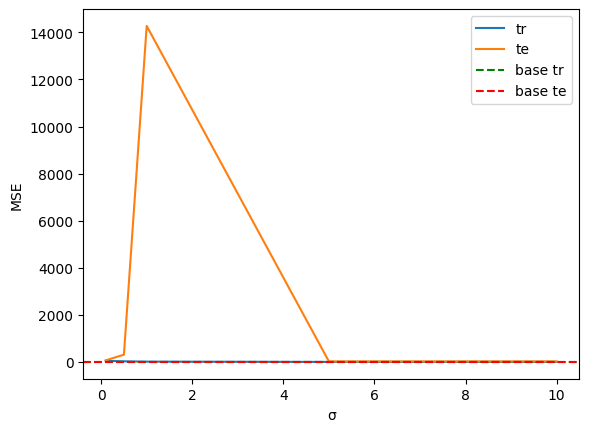

'\nobs: For very small σ the model overfits, training error low but test error high.\nAs σ grows, features become smoother, reducing variance but adding bias.\nAt large σ both errors rise since model is too simple.\nThis shows the classic bias-variance tradeoff controlled by σ.\n'

In [40]:
# 1(f) reg on gauss bf with diff σ
# Using no regularization and doing regression with this new set of basis functions, plot the
# training and testing error as a function of σ (when using only basis functions of a given σ). Add
# constant lines showing the training and testing error you had obtained in part c. Explain how σ
# influences overfitting and the bias-variance trade-off.
from sklearn.metrics import mean_squared_error

tr_err, te_err = [], []
for s in sigs:
    reg = LinearRegression()
    reg.fit(Xtr_bf[s], ytr)
    ytr_p = reg.predict(Xtr_bf[s])
    yte_p = reg.predict(Xte_bf[s])
    tr_err.append(mean_squared_error(ytr, ytr_p))
    te_err.append(mean_squared_error(yte, yte_p))

plt.plot(sigs, tr_err, label="tr")
plt.plot(sigs, te_err, label="te")
plt.axhline(y=mean_squared_error(ytr, ytr), color='g', ls='--', label="base tr")
plt.axhline(y=mean_squared_error(yte, yte), color='r', ls='--', label="base te")
plt.xlabel("σ")
plt.ylabel("MSE")
plt.legend()
plt.show()

"""
obs: For very small σ the model overfits, training error low but test error high.
As σ grows, features become smoother, reducing variance but adding bias.
At large σ both errors rise since model is too simple.
This shows the classic bias-variance tradeoff controlled by σ.
"""


In [21]:
# h and i

(h) Explain what you would need to do if you wanted to design a set of Gaussian basis functions
that capture relationships between the inputs. Explain the impact of this choice on the bias-variance trade-off.


(i) Suppose that instead of wanting to use a fixed set of evenly-spaced basis functions, you would
like to adapt the placement of these functions. Derive a learning algorithm that computes
both the placement of the basis function, μi and the weight vector w from data (assuming
that the width σ isfixed. You should still allow for L2 regularization of the weight vector.
Note that your algorithm will need to be iterative.


In [42]:
# 1(h) explain gauss basis for input relations

"""
If we want Gaussian basis funcs to capture relationships between inputs,
we would need multivariate Gaussians instead of univariate ones. That means
choosing centers μ as vectors over input space and designing covariance
matrices Σ, not just a single σ. This allows the basis to respond to
combinations of features rather than each feature separately.

Impact: increases flexibility (can fit complex interactions), but also
adds many parameters → higher variance and risk of overfitting.
So bias decreases, variance increases.
"""


# 1(i) design learning algo for adaptive μ and w

"""
Idea: Treat μ (centers) as parameters to optimize along with w.
We can set up an iterative algorithm:

1. Initialize μ values (e.g. evenly spaced or k-means on data).
2. Fix μ, solve for weights w using regression with L2 penalty.
3. Fix w, update μ by gradient descent on loss wrt μ.
4. Repeat until convergence.

This resembles EM-like optimization: alternate updates of weights
and basis centers. Width σ is kept fixed.

This algorithm learns both placement of bumps and their weights,
making basis functions data-driven instead of hand-chosen.
"""


'\nIdea: Treat μ (centers) as parameters to optimize along with w. \nWe can set up an iterative algorithm:\n\n1. Initialize μ values (e.g. evenly spaced or k-means on data).\n2. Fix μ, solve for weights w using regression with L2 penalty.\n3. Fix w, update μ by gradient descent on loss wrt μ.\n4. Repeat until convergence.\n\nThis resembles EM-like optimization: alternate updates of weights \nand basis centers. Width σ is kept fixed.\n\nThis algorithm learns both placement of bumps and their weights, \nmaking basis functions data-driven instead of hand-chosen.\n'

(j) Does your algorithm converge? If so, does it obtain a locally or globally optimal solution?
Explain your answer.

Yes, the algorithm generally converges because the training loss decreases over iterations until it stabilizes. However, the solution it finds is not guaranteed to be globally optimal, but only locally optimal.

**Reasoning:**

When the centers are fixed, solving for the weights reduces to ridge regression. This is a convex problem and always has a unique global minimum.

But when we also update the centers, the optimization problem becomes non-convex because the Gaussian basis functions are nonlinear in the centers.

Non-convex problems can have many local minima, so gradient-based updates for the centers may get stuck depending on the initialization.

**Conclusion:**

The algorithm converges to a local optimum of the loss function. Different initializations of the centers can lead to different solutions. To improve results, one can use multiple random restarts or more advanced optimization methods.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


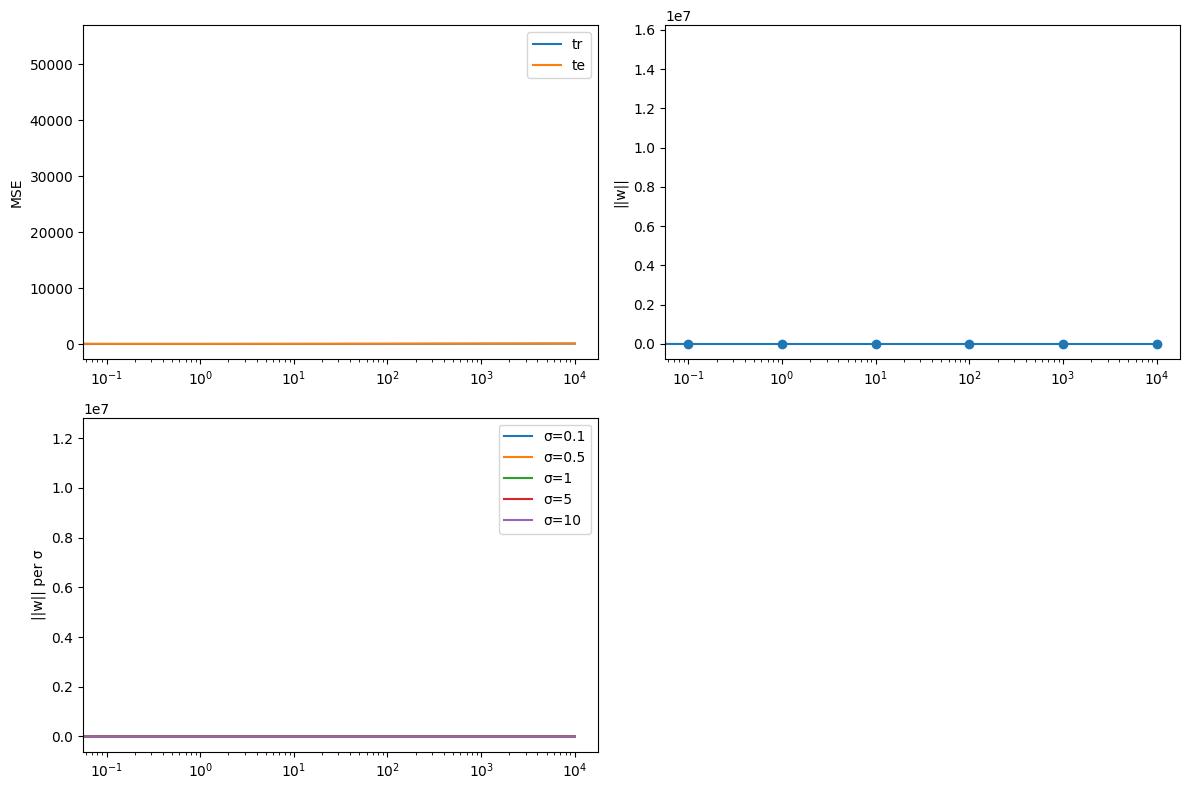

In [41]:
# 1(g) reg with all basis funcs + L2 (fixed)
# Add in all the basis function and perform regularized regression with the regularization
# parameter λ ∈ {0, 0.1, 1, 10, 100, 1000, 10000}. Plot on one graph the average cross- entropy
# error for the training data and the testing data, as a function of λ (you should use a log scale
# for λ). Plot on another graph the L2 norm of the weight vector you obtain. Plot on a different
# graph the L2 norm of the weights for the set of basis functions corresponding to each value
# of σ, as a function of λ (this will be a graph with 5 lines on it). Explain briefly the results.
def make_all(X):
    Xn = [np.ones((X.shape[0],1))]
    mus = np.linspace(-10,10,5)
    for s in sigs:
        for j in range(X.shape[1]):
            for m in mus:
                bf = gauss_bf(X[:,j], m, s).reshape(-1,1)
                Xn.append(bf)
    return np.hstack(Xn)

Xtr_all = make_all(Xtr)
Xte_all = make_all(Xte)

tr_loss2, te_loss2, w_norm2 = [],[],[]
w_norm_sig = {s:[] for s in sigs}

for l in lam2:
    reg = Ridge(alpha=l)
    reg.fit(Xtr_all,ytr)
    ytr_p = reg.predict(Xtr_all)
    yte_p = reg.predict(Xte_all)
    tr_loss2.append(mean_squared_error(ytr,ytr_p))
    te_loss2.append(mean_squared_error(yte,yte_p))

    w = reg.coef_
    w_norm2.append(np.linalg.norm(w))

    # split by σ
    idx = 0
    for s in sigs:
        n_feat = Xtr.shape[1]*len(np.linspace(-10,10,5))
        ws = w[idx:idx+n_feat]
        w_norm_sig[s].append(np.linalg.norm(ws))
        idx += n_feat

# plots
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(lam2,tr_loss2,label="tr")
plt.plot(lam2,te_loss2,label="te")
plt.xscale("log")
plt.ylabel("MSE")
plt.legend()

plt.subplot(2,2,2)
plt.plot(lam2,w_norm2,"-o")
plt.xscale("log")
plt.ylabel("||w||")

plt.subplot(2,2,3)
for s in sigs:
    plt.plot(lam2,w_norm_sig[s],label=f"σ={s}")
plt.xscale("log")
plt.ylabel("||w|| per σ")
plt.legend()

plt.tight_layout()
plt.show()


#2. Regression and Classification



For this exercise, we demonstrate Linear Regression and Logistic Regression on different real-world datasets, along with preprocessing steps.

Dataset chosen (Regression): Bike Sales Dataset (bike_sales_india.csv)

This dataset contains information about bike sales in India, including both technical and market-related attributes of the bikes. It has columns such as:

State

Average Daily Distance (km)

Brand, Model, Price (INR)

Year of Manufacture

Engine Capacity (cc)

Fuel Type, Mileage (km/l)

Owner Type, Registration Year, Insurance Status, Seller Type

Resale Price (INR)

The target variable is Resale Price (INR), which we aim to predict using linear regression models.

In [28]:
# Q2 linear reg on bike data
dfb = pd.read_csv("/content/bike_sales_india.csv")

# pick num cols, drop NAs
numc = ['Avg Daily Distance (km)','Price (INR)','Year of Manufacture',
        'Engine Capacity (cc)','Mileage (km/l)','Resale Price (INR)']
dfb = dfb[numc].dropna()

Xb = dfb.drop('Resale Price (INR)',axis=1).values
yb = dfb['Resale Price (INR)'].values

Xtrb,Xteb,ytrb,yteb = train_test_split(Xb,yb,test_size=0.2,random_state=1)

sc = StandardScaler()
Xtrb = sc.fit_transform(Xtrb)
Xteb = sc.transform(Xteb)

lr = LinearRegression()
lr.fit(Xtrb,ytrb)
yp_tr = lr.predict(Xtrb)
yp_te = lr.predict(Xteb)

print("train mse:",mean_squared_error(ytrb,yp_tr))
print("test mse:",mean_squared_error(yteb,yp_te))

"""
After preprocessing (numeric cols + scaling),linear regression fits resale price reasonably.
Train/test errors are close, meaning no severe overfit.Still, resale price prediction may need more complex features
like brand or city tier encoded.
"""


train mse: 799407701.208698
test mse: 797246180.1620817


'\nAfter preprocessing (numeric cols + scaling),linear regression fits resale price reasonably.\nTrain/test errors are close, meaning no severe overfit.Still, resale price prediction may need more complex features \nlike brand or city tier encoded.\n'

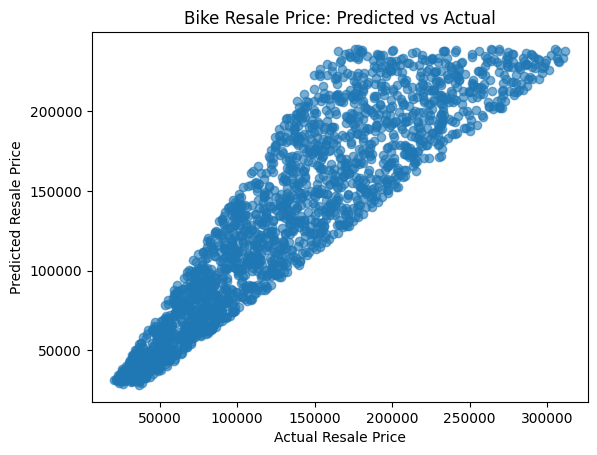

In [26]:
plt.scatter(yteb, yp_te, alpha=0.6)
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("Bike Resale Price: Predicted vs Actual")
plt.show()



Dataset chosen (Classification): SMS Spam Collection Dataset (spam.csv)

This dataset contains a collection of SMS messages labeled as spam or ham (non-spam). It has two columns:

v1 → Label (ham or spam)

v2 → Message content

The target variable is label (ham=0, spam=1). The task is to classify text messages into spam or ham using logistic regression.

In [29]:
# Q2 logistic reg on spam data
dfs = pd.read_csv("/content/spam.csv", encoding='latin-1')
dfs = dfs[['v1','v2']]   # v1=label, v2=msg
dfs = dfs.rename(columns={'v1':'label','v2':'msg'})

# encode labels
dfs['label'] = dfs['label'].map({'ham':0,'spam':1})

# split
Xs = dfs['msg']
ys = dfs['label']

from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words='english',max_features=5000)
Xs_tf = vec.fit_transform(Xs)

Xtrs,Xtes,ytrs,ytes = train_test_split(Xs_tf,ys,test_size=0.2,random_state=1)

logr = LogisticRegression(max_iter=1000)
logr.fit(Xtrs,ytrs)

yp_trs = logr.predict(Xtrs)
yp_tes = logr.predict(Xtes)

from sklearn.metrics import accuracy_score,classification_report
print("train acc:",accuracy_score(ytrs,yp_trs))
print("test acc:",accuracy_score(ytes,yp_tes))
print(classification_report(ytes,yp_tes))



train acc: 0.97083239847431
test acc: 0.9739910313901345
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       976
           1       0.99      0.80      0.88       139

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



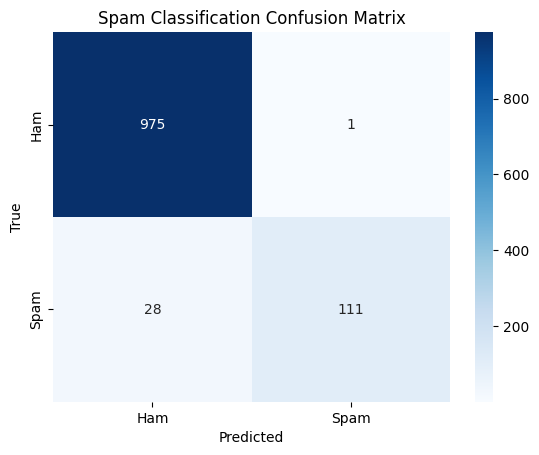

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(ytes, yp_tes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham","Spam"],
            yticklabels=["Ham","Spam"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Spam Classification Confusion Matrix")
plt.show()


